In [2]:
import xarray as xr
from dask.diagnostics.progress import ProgressBar

In [ ]:
da = xr.open_zarr('../data/intermediate/evp_1200itr_long.zarr')

def lat_filter(x: xr.DataArray, threshold):
    mask = x.lat.values >= threshold if threshold > 0 else x.lat.values <= threshold
    return x.isel(z=mask)

with ProgressBar():
    print("masking arctic")
    da = lat_filter(da, 80)
    print("saving to zarr")
    da = da.drop_encoding()
    da.to_zarr('../data/processed/arctic/80deg.zarr', mode='w', align_chunks=True, zarr_format=2)

    #print("antarctic mask")
    #antarctic = lat_filter(da, -50)
    #print(" saving to zarr")
    #antarctic.to_zarr('../data/processed/full_antarctic.zarr', mode='w', zarr_format=2, align_chunks=True)


masking arctic
[########################################] | 100% Completed | 610.63 ms
saving to zarr
[########################################] | 100% Completed | 2.96 sms
[########################################] | 100% Completed | 170.08 s
[########################################] | 100% Completed | 3.36 ss
[########################################] | 100% Completed | 175.79 s
[########################################] | 100% Completed | 481.50 s


In [ ]:
month_subsets = [1]
da = xr.open_zarr('../data/processed/arctic/80deg.zarr')

with ProgressBar():
    for month_subset in month_subsets:
        print(f"subsetting to max month {month_subset}")
        mask = (da.time_features.dt.month.values <= month_subset)
        arctic_subset = da.isel(z=mask)
        arctic_subset.to_zarr(f'../data/processed/arctic/{month_subset}.zarr', mode='w', align_chunks=True, zarr_format=2)

subsetting to max month 1
[########################################] | 100% Completed | 102.75 ms
[########################################] | 100% Completed | 19.37 s
[########################################] | 100% Completed | 385.92 ms
[########################################] | 100% Completed | 396.34 ms
[########################################] | 100% Completed | 14.42 s


In [37]:
import xarray.ufuncs as ufuncs

da = xr.open_zarr('../data/processed/arctic/80deg.zarr')

print('calculating d(sivelu)')
d_sivelu = ufuncs.abs((da.features.loc["sivelu"] - da.labels.loc["sivelu"]))
print('calculating d(sivelv)')
d_sivelv = ufuncs.abs((da.features.loc["sivelv"] - da.labels.loc["sivelv"]))

da = da.assign({
    'd_labels': xr.concat([d_sivelu, d_sivelv], dim='d_label')
})
da = da.assign_coords({
    'd_label': ['d_sivelu', 'd_sivelv']
})

print('saving to zarr')
da.to_zarr('../data/processed/arctic/80deg_diff.zarr', mode='w', zarr_format=2)

calculating d(sivelu)
calculating d(sivelv)
saving to zarr


In [20]:
xr.open_zarr('../data/processed/arctic/80deg.zarr')

<xarray.Dataset> Size: 1GB
Dimensions:        (feature: 10, z: 13036676, label: 2)
Coordinates:
  * feature        (feature) <U7 280B 'siconc' 'sithic' ... 'sidive' 'sishea'
  * label          (label) <U6 48B 'sivelv' 'sivelu'
    lat            (z) float32 52MB dask.array<chunksize=(494831,), meta=np.ndarray>
    lon            (z) float32 52MB dask.array<chunksize=(494831,), meta=np.ndarray>
    pair           (z) int64 104MB dask.array<chunksize=(247415,), meta=np.ndarray>
    time_features  (z) object 104MB dask.array<chunksize=(247415,), meta=np.ndarray>
    time_labels    (z) object 104MB dask.array<chunksize=(247415,), meta=np.ndarray>
    x              (z) int64 104MB dask.array<chunksize=(247415,), meta=np.ndarray>
    y              (z) int64 104MB dask.array<chunksize=(247415,), meta=np.ndarray>
Dimensions without coordinates: z
Data variables:
    features       (feature, z) float32 521MB dask.array<chunksize=(1, 1735299), meta=np.ndarray>
    labels         (label, z) float32 104MB dask.array<chunksize=(1, 1735299), meta=np.ndarray>

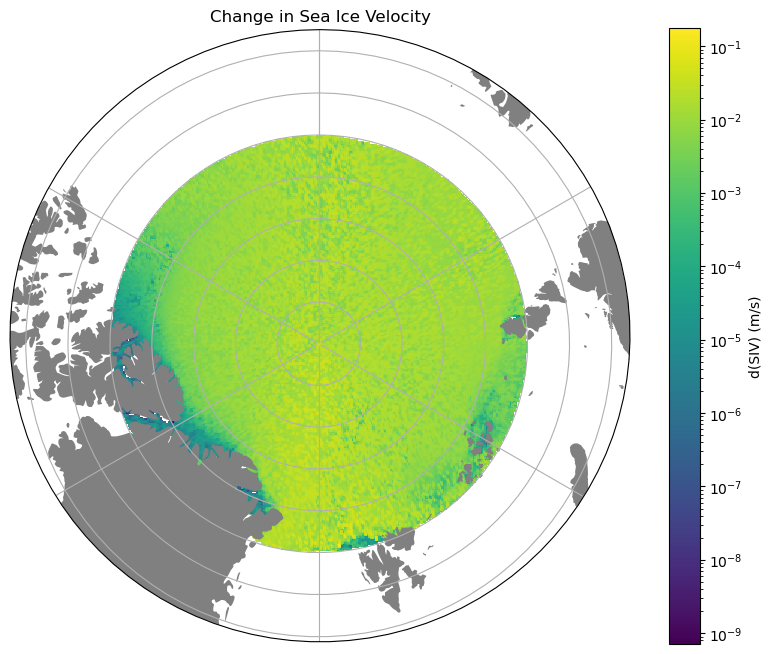

In [6]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import cKDTree

da = xr.open_zarr('../data/processed/arctic/80deg.zarr')

diff = np.abs((da.features.loc["sivelv"] - da.labels.loc["sivelv"]).values)[:100000]
lat = da.coords['lat'].values[:100000]
lon = da.coords['lon'].values[:100000]

projection = ccrs.NorthPolarStereo()
extent = [-180, 180, 75, 90]

# Source coord system is lon/lat
src_crs = ccrs.PlateCarree()

# Transform to meters
coords_proj = projection.transform_points(src_crs, lon, lat)
x_points = coords_proj[:, 0]
y_points = coords_proj[:, 1]

grid_x_2d, grid_y_2d = np.meshgrid(
np.linspace(-4000000, 4000000, 1000),
np.linspace(-4000000, 4000000, 1000)
)

grid_interpolated = griddata(
(x_points, y_points),
diff,
(grid_x_2d, grid_y_2d),
method='linear'
)

# Mask points that are threshold_meters from any datapoint
threshold_meters = 50000

tree = cKDTree(np.column_stack((x_points, y_points)))
grid_pixels = np.column_stack((grid_x_2d.ravel(), grid_y_2d.ravel()))
dist, _ = tree.query(grid_pixels)
dist = dist.reshape(grid_x_2d.shape)
grid_interpolated[dist > threshold_meters] = np.nan

# Create plot and add coastlines
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=projection)
ax.set_extent(extent, src_crs)
ax.add_feature(cfeature.LAND, zorder=2, facecolor='gray')
#ax.coastlines(resolution='110m', zorder=2)
ax.gridlines()

# Create circular boundary
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

mesh = ax.pcolormesh(
    grid_x_2d, grid_y_2d, 
    grid_interpolated,
    transform=projection,
    norm=colors.LogNorm(),
    cmap='viridis',
    shading='auto'
)

plt.colorbar(mesh, ax=ax, label='d(SIV) (m/s)')
plt.title("Change in Sea Ice Velocity")
plt.show()